**Data Loading**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:

data_path = '/content/drive/MyDrive/ProjectData/HRAST.csv'


In [ ]:
import pandas as pd

df = pd.read_csv(data_path)
print(df.head())


   id                                             review Unnamed: 2  positive  \
0   1                            1 elevator not working.        NaN         0   
1   2     1 euros to park per day on their own premises.        NaN         0   
2   3                          1 hour queue to check-in.        NaN         0   
3   4  1 min walk to metro entrance and also few min ...        NaN         1   
4   5  1 minute walk from the main metro & train stat...        NaN         1   

   negative  neutral  Clean  Comfort  Facilities/Amenities  Location  ...  \
0         1        0      0        0                     0         0  ...   
1         0        1      0        0                     0         0  ...   
2         1        0      0        0                     0         0  ...   
3         0        0      0        0                     0         1  ...   
4         0        0      0        0                     0         1  ...   

   Bar  Bed  Parking  Noise  Reception-checkin  Li

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23113 entries, 0 to 23112
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   id                        23113 non-null  int64 
 1   review                    23113 non-null  object
 2   Unnamed: 2                79 non-null     object
 3   positive                  23113 non-null  int64 
 4   negative                  23113 non-null  int64 
 5   neutral                   23113 non-null  int64 
 6   Clean                     23113 non-null  int64 
 7   Comfort                   23113 non-null  int64 
 8   Facilities/Amenities      23113 non-null  int64 
 9   Location                  23113 non-null  int64 
 10  Restaurant (dinner)       23113 non-null  int64 
 11  Staff                     23113 non-null  int64 
 12  View (Balcony)            23113 non-null  int64 
 13  Breakfast                 23113 non-null  int64 
 14  Room                  

In [ ]:
df.drop(columns=['Unnamed: 2', 'id','Generic'], inplace=True)

In [ ]:
df['Location'] = df['Location'].astype(int)

In [ ]:
#Text Cleaning
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)  # remove HTML
    text = re.sub(r'[^a-z\s]', '', text)  # keep only letters
    text = re.sub(r'\s+', ' ', text).strip()  # remove extra spaces
    return text

df['clean_review'] = df['review'].apply(clean_text)
df['clean_review']

,clean_review
0,elevator not working
1,euros to park per day on their own premises
2,hour queue to checkin
3,min walk to metro entrance and also few min wa...
4,minute walk from the main metro train station ...
...,...
23108,young staff that deserves success
23109,young clean a stones throw from the city center
23110,young friendly and helpful staff
23111,young very friendly and attentive staff at rec...


In [ ]:
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt_tab')

df['tokens'] = df['clean_review'].apply(word_tokenize)


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
df['tokens']

,tokens
0,"[elevator, not, working]"
1,"[euros, to, park, per, day, on, their, own, pr..."
2,"[hour, queue, to, checkin]"
3,"[min, walk, to, metro, entrance, and, also, fe..."
4,"[minute, walk, from, the, main, metro, train, ..."
...,...
23108,"[young, staff, that, deserves, success]"
23109,"[young, clean, a, stones, throw, from, the, ci..."
23110,"[young, friendly, and, helpful, staff]"
23111,"[young, very, friendly, and, attentive, staff,..."


In [ ]:
pip install spacy

In [ ]:
import spacy

# Load the English model
nlp = spacy.load('en_core_web_sm')


In [ ]:


df['lemmas'] = df['clean_review'].apply(lambda x: [token.lemma_ for token in nlp(x)])


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report


# Define aspect columns
aspect_cols = ['Clean', 'Comfort', 'Facilities/Amenities', 'Location',
               'Restaurant (dinner)', 'Staff', 'View (Balcony)', 'Breakfast',
               'Room', 'Pool', 'Beach', 'Bathroom/Shower (toilet)', 'Bar',
               'Bed', 'Parking', 'Noise', 'Reception-checkin', 'Lift',
               'Value for money', 'Wi-Fi']

# Aspect Extraction (baseline multi-label) ---
X = df['clean_review']
y_aspect = df[aspect_cols]

In [ ]:
# First split: 70% train, 30% temp (will split temp into val/test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_aspect, test_size=0.3, random_state=42
)


In [ ]:
# Split temp into validation and test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)


In [ ]:
# TF-IDF Transformation

tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)
X_test_tfidf = tfidf.transform(X_test)


In [ ]:
# Multi-label Logistic Regression
lr = LogisticRegression(max_iter=1000)
multi_label_model = MultiOutputClassifier(lr)
multi_label_model.fit(X_train_tfidf, y_train)

MultiOutputClassifier(estimator=LogisticRegression(max_iter=1000))

In [ ]:
# Predictions
y_pred_aspect = multi_label_model.predict(X_test_tfidf)
print("Aspect Extraction Baseline:")
print(classification_report(y_test, y_pred_aspect, target_names=aspect_cols))


Aspect Extraction Baseline:
                          precision    recall  f1-score   support

                   Clean       0.99      0.75      0.86       480
                 Comfort       0.88      0.64      0.74       367
    Facilities/Amenities       0.94      0.53      0.68       438
                Location       0.99      0.88      0.93       743
     Restaurant (dinner)       1.00      0.21      0.34        39
                   Staff       0.98      0.82      0.89       588
          View (Balcony)       0.96      0.62      0.76       112
               Breakfast       0.99      0.86      0.92       392
                    Room       0.81      0.67      0.73       697
                    Pool       0.98      0.76      0.86        63
                   Beach       1.00      0.37      0.54        30
Bathroom/Shower (toilet)       0.95      0.78      0.86       357
                     Bar       0.95      0.37      0.53        54
                     Bed       0.94      0.72  

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
pip install gensim

In [ ]:
from gensim.models import Word2Vec
import numpy as np

#  1. Tokenize existing splits ---
X_train_tokens = [text.split() for text in X_train]
X_val_tokens = [text.split() for text in X_val]
X_test_tokens = [text.split() for text in X_test]

In [ ]:
# 2. Train Word2Vec on training data only ---
w2v_model = Word2Vec(
    sentences=X_train_tokens,
    vector_size=100,
    window=5,
    min_count=2,
    workers=4,
    sg=1
)

In [ ]:
# 3. Build average sentence vectors ---
def get_sentence_vector(tokens, model, vector_size=100):
    vecs = [model.wv[word] for word in tokens if word in model.wv]
    if len(vecs) == 0:
        return np.zeros(vector_size)
    return np.mean(vecs, axis=0)


X_train_vecs = np.array([get_sentence_vector(tokens, w2v_model) for tokens in X_train_tokens])
X_val_vecs = np.array([get_sentence_vector(tokens, w2v_model) for tokens in X_val_tokens])
X_test_vecs = np.array([get_sentence_vector(tokens, w2v_model) for tokens in X_test_tokens])

In [ ]:
# 4. Logistic Regression (same as TF-IDF) ---
lr_w2v = LogisticRegression(max_iter=1000)
multi_label_w2v = MultiOutputClassifier(lr_w2v)
multi_label_w2v.fit(X_train_vecs, y_train)

MultiOutputClassifier(estimator=LogisticRegression(max_iter=1000))

In [ ]:
# 5. Validation Evaluation ---
y_val_pred_w2v = multi_label_w2v.predict(X_val_vecs)
print("Aspect Extraction (Word2Vec Baseline) - Validation Set")
print(classification_report(y_val, y_val_pred_w2v, target_names=aspect_cols))

Aspect Extraction (Word2Vec Baseline) - Validation Set
                          precision    recall  f1-score   support

                   Clean       0.87      0.38      0.52       416
                 Comfort       0.82      0.52      0.64       394
    Facilities/Amenities       0.84      0.34      0.49       448
                Location       0.94      0.83      0.88       710
     Restaurant (dinner)       0.00      0.00      0.00        51
                   Staff       0.96      0.76      0.85       515
          View (Balcony)       0.85      0.40      0.54       125
               Breakfast       0.96      0.64      0.76       384
                    Room       0.79      0.57      0.66       771
                    Pool       1.00      0.55      0.71        65
                   Beach       0.00      0.00      0.00        30
Bathroom/Shower (toilet)       0.87      0.55      0.68       355
                     Bar       1.00      0.05      0.10        59
                    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_

In [ ]:
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# --- Calculate F1 per aspect for TF-IDF ---
f1_tfidf = []
for i, aspect in enumerate(aspect_cols):
    f1 = f1_score(y_val.iloc[:, i], y_pred_aspect[:, i], average='binary')
    f1_tfidf.append(f1)

# --- Calculate F1 per aspect for Word2Vec ---
f1_w2v = []
for i, aspect in enumerate(aspect_cols):
    f1 = f1_score(y_val.iloc[:, i], y_val_pred_w2v[:, i], average='binary')
    f1_w2v.append(f1)

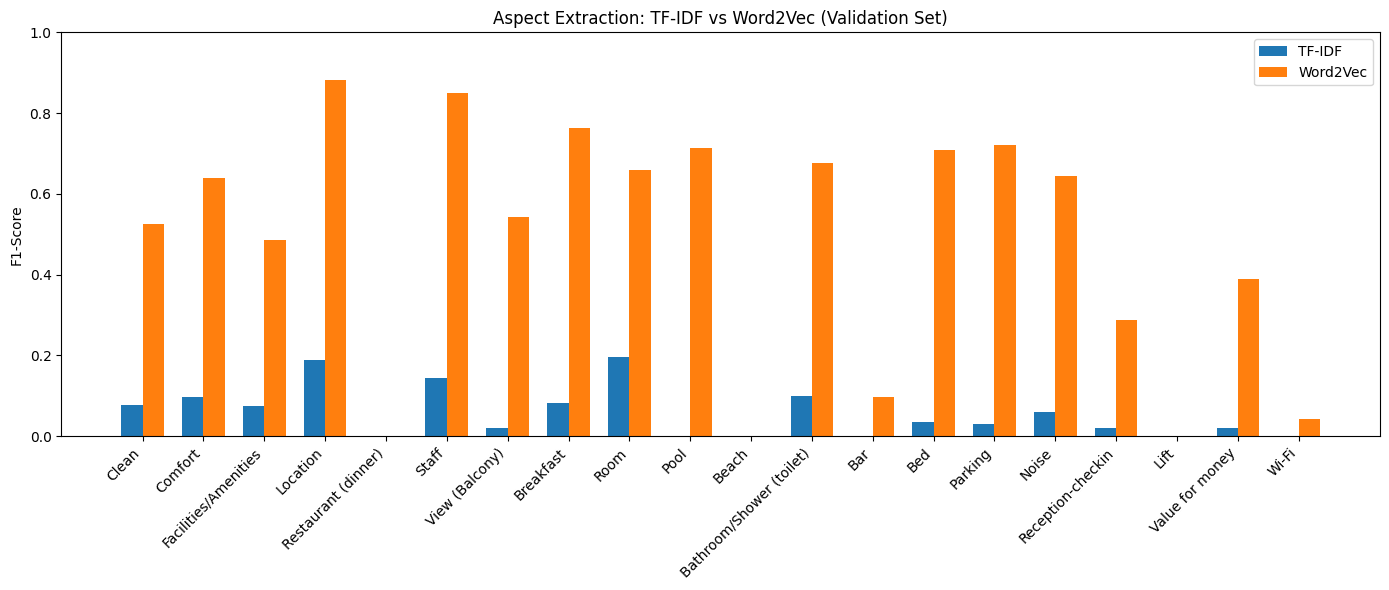

In [ ]:
x = np.arange(len(aspect_cols))  # label locations
width = 0.35  # width of bars

fig, ax = plt.subplots(figsize=(14,6))
rects1 = ax.bar(x - width/2, f1_tfidf, width, label='TF-IDF')
rects2 = ax.bar(x + width/2, f1_w2v, width, label='Word2Vec')

# Labels and title
ax.set_ylabel('F1-Score')
ax.set_title('Aspect Extraction: TF-IDF vs Word2Vec (Validation Set)')
ax.set_xticks(x)
ax.set_xticklabels(aspect_cols, rotation=45, ha='right')
ax.legend()
plt.ylim(0, 1)  # F1-score ranges from 0 to 1
plt.tight_layout()
plt.show()


In [ ]:
# Average F1 for TF-IDF
avg_f1_tfidf = np.mean(f1_tfidf)

# Average F1 for Word2Vec
avg_f1_w2v = np.mean(f1_w2v)

print("Average F1-Score Across All Aspects:")
print(f"TF-IDF: {avg_f1_tfidf:.3f}")
print(f"Word2Vec: {avg_f1_w2v:.3f}")


Average F1-Score Across All Aspects:
TF-IDF: 0.057
Word2Vec: 0.481


In [ ]:

summary_df = pd.DataFrame({
    'Representation': ['TF-IDF', 'Word2Vec'],
    'Average F1-Score': [avg_f1_tfidf, avg_f1_w2v]
})

print(summary_df)


  Representation  Average F1-Score
0         TF-IDF          0.057344
1       Word2Vec          0.481238


In [ ]:
# Aspect-level Sentiment Classification ---

# Helper: convert one-hot to single label
def onehot_to_label(row):
    if row['positive'] == 1:
        return 'positive'
    elif row['negative'] == 1:
        return 'negative'
    else:
        return 'neutral'

sentiment_cols = ['positive', 'negative', 'neutral']

for aspect in aspect_cols:
    # Only consider reviews where aspect is present
    mask = df[aspect] == 1
    X_aspect = df.loc[mask, 'clean_review']
    y_aspect_sent = df.loc[mask, sentiment_cols].apply(onehot_to_label, axis=1)

    if len(X_aspect) == 0:
        continue  # skip aspect if no data

In [ ]:
# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y_aspect_sent)
all_classes = le.classes_

In [ ]:
# Split 70/15/15
X_train_s, X_temp_s, y_train_s, y_temp_s = train_test_split(X_aspect, y_encoded, test_size=0.3, random_state=42)
X_val_s, X_test_s, y_val_s, y_test_s = train_test_split(X_temp_s, y_temp_s, test_size=0.5, random_state=42)


In [ ]:
# TF-IDF
X_train_tfidf_s = tfidf.fit_transform(X_train_s)
X_val_tfidf_s = tfidf.transform(X_val_s)
X_test_tfidf_s = tfidf.transform(X_test_s)

In [ ]:
# Logistic Regression (multi-class)
clf = LogisticRegression(max_iter=1000, multi_class='multinomial')
clf.fit(X_train_tfidf_s, y_train_s)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='multinomial')

In [ ]:
 # Evaluate on validation set
y_val_pred_s = clf.predict(X_val_tfidf_s)
print(f"Sentiment Classification for Aspect: {aspect} - Validation Set")
print(classification_report(
        y_val_s,
        y_val_pred_s,
        labels=le.transform(all_classes),  # ensure all classes are included
        target_names=all_classes,
        zero_division=0  # prevents division by zero
    ))

Sentiment Classification for Aspect: Wi-Fi - Validation Set
              precision    recall  f1-score   support

    negative       0.73      1.00      0.84        27
     neutral       0.00      0.00      0.00         0
    positive       1.00      0.23      0.38        13

    accuracy                           0.75        40
   macro avg       0.58      0.41      0.41        40
weighted avg       0.82      0.75      0.69        40

